<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Armado de Datasets</h4>
</center>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
warnings.filterwarnings("ignore")

date_start=datetime.strptime('2017-01-01', '%Y-%m-%d')
date_end=datetime.strptime('2019-12-01', '%Y-%m-%d')
forecast_length = 2
date_future=date_end+relativedelta(months=forecast_length)
years=range(2018, 2020)

In [2]:
print(f"Fecha inicio historia {date_start}")
print(f"Fecha fin historia {date_end}")
print(f"Fecha futura (related time series) {date_future}")

Fecha inicio historia 2017-01-01 00:00:00
Fecha fin historia 2019-12-01 00:00:00
Fecha futura (related time series) 2020-02-01 00:00:00


- Skus a predecir

In [3]:
skus_a_predecir = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/productos_a_predecir.txt", delimiter='\t')
skus_a_predecir = skus_a_predecir.product_id.to_list()

- Datos de ventas

In [4]:
df_ventas = pd.read_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/sell-in.txt", delimiter='\t')
df_ventas['periodo'] = df_ventas['periodo'].astype(str)
df_ventas['periodo'] = pd.to_datetime(df_ventas['periodo'], format='%Y%m')
df_ventas = df_ventas[df_ventas.product_id.isin(skus_a_predecir)]
df_ventas.head(1)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,2017-01-01,10234,20524,0,2,0.053,0.053


In [5]:
print(f"Cantidad productos finales a predecir: {len(df_ventas.product_id.drop_duplicates())}")

Cantidad productos finales a predecir: 780


Dataset de ventas para predecir unicamente por periodo y producto:

In [6]:
df_ventas_product = df_ventas.groupby(["periodo", "product_id"])["tn"].sum().reset_index()
df_ventas_product.head(1)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222


In [7]:
df_ventas_product.isna().sum()

periodo       0
product_id    0
tn            0
dtype: int64

In [8]:
df_ventas_product.tn.sum().round(1) == df_ventas.tn.sum().round(1) 

True

- Cortamos outliers

In [9]:
# FUNCION PARA IDENTIFICAR OUTLIERS
def calculate_sales_extreme_values_by_percentile_method(df, lower_quantile=0.05, upper_quantile=0.95, grouped_columns=[]):
    '''Calculates sales extreme values for those that are 
    greater/less than a lower/upper percentile.
    '''
    def upperextreme(x):
        '''Define Upper Extreme'''
        return x.quantile(q=upper_quantile)
    def lowerextreme(x):
        '''Define Lower Extreme'''
        return x.quantile(q=lower_quantile)
    
    # Calculate extreme values by grouped_columns
    df_lower_upper_extremes = df.groupby(grouped_columns)["tn"].agg([lowerextreme, upperextreme]).reset_index()
    
    # Add extreme value dummies
    df = (df
         .merge(df_lower_upper_extremes, on = grouped_columns)
         .assign(
             lowerextremepoint = lambda x: x.tn < x.lowerextreme,
             upperextremepoint = lambda x: x.tn > x.upperextreme)
         .assign(
             lowerextremepoint = lambda x: x.lowerextremepoint.astype('int64'),
             upperextremepoint = lambda x: x.upperextremepoint.astype('int64'))
         .drop(columns = ['lowerextreme', 'upperextreme'])
    )
    # Seteamos valores nan para periodo futuro
    df["lowerextremepoint"] = np.where(df["periodo"] <= date_end, df["lowerextremepoint"], np.nan)
    df["upperextremepoint"] = np.where(df["periodo"] <= date_end, df["upperextremepoint"], np.nan)
    return df

df_ventas_product_out = calculate_sales_extreme_values_by_percentile_method(df_ventas_product, 
                                                                            lower_quantile=0.05, 
                                                                            upper_quantile=0.95, 
                                                                            grouped_columns=["product_id"])

# FUNCIÓN PARA IDENTIFICAR OUTLIERS Y LLEVAR LOS VALORES OUTLIERS AL MÁXIMO Y MÍNIMO ESTIPULADOS EN LOS PERCENTILES
def fill_sales_extreme_values_by_percentile_method(df, lower_quantile=0.05, upper_quantile=0.95, grouped_columns=[]):
    '''Calculates sales extreme values for those that are 
    greater/less than a lower/upper percentile and fills them with the 
    lower/upper percentile value respectively.
    '''
    def upperextreme(x):
        '''Define Upper Extreme'''
        return x.quantile(q=upper_quantile)
    def lowerextreme(x):
        '''Define Lower Extreme'''
        return x.quantile(q=lower_quantile)
    
    # Calculate extreme values by grouped_columns
    df_lower_upper_extremes = df.groupby(grouped_columns)["tn"].agg([lowerextreme, upperextreme]).reset_index()
    
    # Merge the extreme values back to the original dataframe
    df = df.merge(df_lower_upper_extremes, on=grouped_columns)
    # Replace lower extreme values with lower quantile value
    df['tn'] = np.where(df['tn'] < df['lowerextreme'], df['lowerextreme'], df['tn'])
    # Replace upper extreme values with upper quantile value
    df['tn'] = np.where(df['tn'] > df['upperextreme'], df['upperextreme'], df['tn'])
    # Drop the extreme value columns as they are no longer needed
    df = df.drop(columns=['lowerextreme', 'upperextreme'])
    return df

df_ventas_product_cut = fill_sales_extreme_values_by_percentile_method(df_ventas_product, 
                                                                       lower_quantile=0.05, 
                                                                       upper_quantile=0.95, 
                                                                       grouped_columns=["product_id"])

In [10]:
def plot_outliers(df_original, df_adjusted):
    '''
    Grafica la serie de tiempo de tn, marcando con puntos rojos los lowerextremepoint y upperextremepoint.
    Además, grafica la serie ajustada.
    
    Parámetros:
    df_original (pd.DataFrame): DataFrame con columnas ['periodo', 'tn', 'lowerextremepoint', 'upperextremepoint']
    df_adjusted (pd.DataFrame): DataFrame ajustado con columnas ['periodo', 'tn']
    '''
    # Convertir 'periodo' a tipo datetime si no lo está
    if not pd.api.types.is_datetime64_any_dtype(df_original['periodo']):
        df_original['periodo'] = pd.to_datetime(df_original['periodo'])
    if not pd.api.types.is_datetime64_any_dtype(df_adjusted['periodo']):
        df_adjusted['periodo'] = pd.to_datetime(df_adjusted['periodo'])
    
    # Filtrar los puntos extremos
    df_lower = df_original[df_original['lowerextremepoint'] == 1]
    df_upper = df_original[df_original['upperextremepoint'] == 1]
    
    # Graficar la serie de tiempo
    plt.figure(figsize=(12, 6))
    plt.plot(df_original['periodo'], df_original['tn'], color='gray', label='Ventas Originales')
    
    # Marcar los lowerextremepoint y upperextremepoint
    plt.scatter(df_lower['periodo'], df_lower['tn'], color='red', label='Lower Outliers')
    plt.scatter(df_upper['periodo'], df_upper['tn'], color='red', label='Upper Outliers')
    
    # Graficar la serie ajustada
    plt.plot(df_adjusted['periodo'], df_adjusted['tn'], color='lightblue', linestyle='--', label='Ventas Ajustadas')
    
    # Añadir título y etiquetas
    plt.title('Ventas con Outliers y Serie Ajustada')
    plt.xlabel('Periodo')
    plt.ylabel('Ventas (tn)')
    plt.legend()
    
    # Mostrar la gráfica
    plt.show()

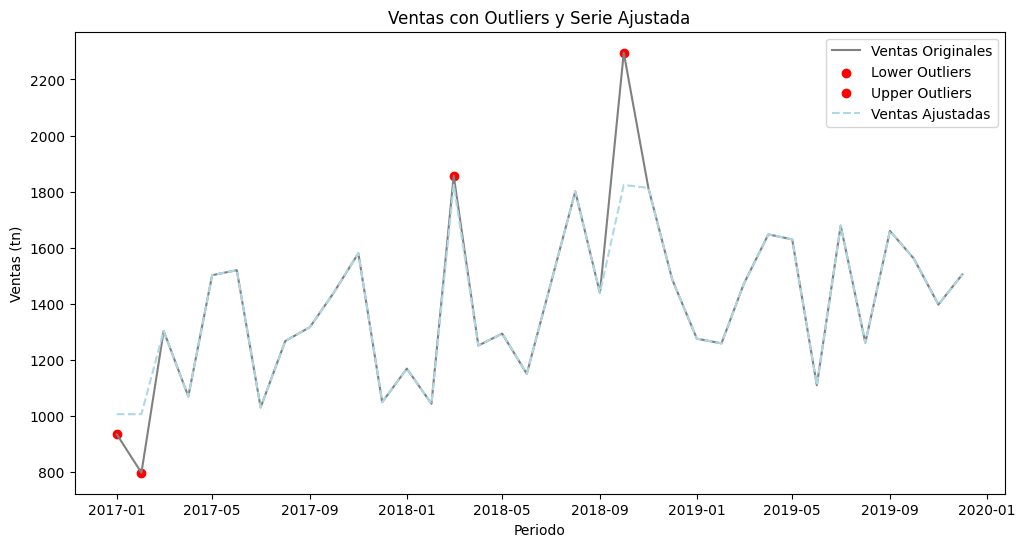

In [11]:
# Seleccionar producto específico para la visualización
product_id_select = 20001
producto_select = df_ventas_product_out[df_ventas_product_out.product_id == product_id_select][["periodo", "tn", "lowerextremepoint", "upperextremepoint"]]
producto_select_adjusted = df_ventas_product_cut[df_ventas_product_cut.product_id == product_id_select][["periodo", "tn"]]
plot_outliers(producto_select, producto_select_adjusted)

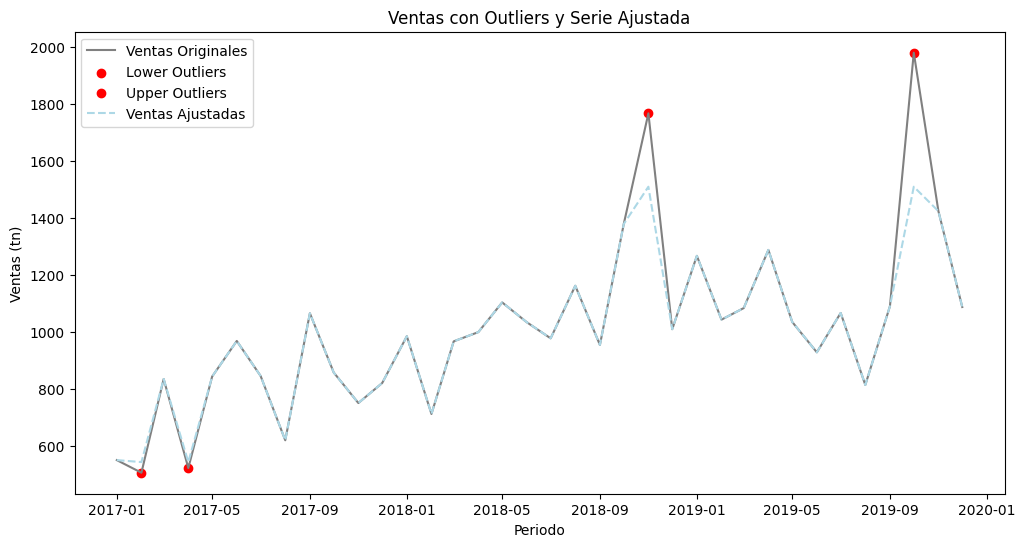

In [12]:
# Seleccionar producto específico para la visualización
product_id_select = 20002
producto_select = df_ventas_product_out[df_ventas_product_out.product_id == product_id_select][["periodo", "tn", "lowerextremepoint", "upperextremepoint"]]
producto_select_adjusted = df_ventas_product_cut[df_ventas_product_cut.product_id == product_id_select][["periodo", "tn"]]
plot_outliers(producto_select, producto_select_adjusted)

In [13]:
# FUNCIÓN PARA IDENTIFICAR OUTLIERS MÁXIMOS Y LLEVAR LOS VALORES AL P95 DE LA DISTRIBUCION
def fill_sales_extreme_upper_values_by_percentile_method(df, upper_quantile=0.95, grouped_columns=[]):
    '''Calculates sales extreme values for those that are greater than an upper percentile
    and fills upper outliers with the upper percentile value.
    '''
    def upperextreme(x):
        '''Define Upper Extreme'''
        return x.quantile(q=upper_quantile)
    
    # Calculate upper extreme values by grouped_columns
    df_upper_extremes = df.groupby(grouped_columns)["tn"].agg([upperextreme]).reset_index()
    # Merge the upper extreme values back to the original dataframe
    df = df.merge(df_upper_extremes, on=grouped_columns)
    # Replace upper extreme values with upper quantile value
    df['tn'] = np.where(df['tn'] > df['upperextreme'], df['upperextreme'], df['tn'])
    # Drop the upper extreme value columns as they are no longer needed
    df = df.drop(columns=['upperextreme'])
    return df

# Aplicación de la función
df_ventas_product_cut_upper = fill_sales_extreme_upper_values_by_percentile_method(df_ventas_product, 
                                                                                   upper_quantile=0.95, 
                                                                                   grouped_columns=["product_id"])

In [14]:
# Exportamos data de ventas product ACOTADA por outliers EXTREMOS INFERIORES Y SUPERIORES
df_ventas_product_export = df_ventas_product_cut[(df_ventas_product_cut['periodo']>=date_start) & (df_ventas_product_cut['periodo']<=date_end)]
df_ventas_product_export['product_id'] = df_ventas_product_export['product_id'].astype(str)
print(f"Min periodo {df_ventas_product_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_export.periodo.max()}")
df_ventas_product_export.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product_fill_extreme_values_005_095.csv", index=False, header=False)
print(f"Tipos por columna: \n{df_ventas_product_export.dtypes}")

Min periodo 2017-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object


In [15]:
# Exportamos data de ventas product ACOTADA por outliers EXTREMOS SUPERIORES
df_ventas_product_export = df_ventas_product_cut_upper[(df_ventas_product_cut_upper['periodo']>=date_start) & (df_ventas_product_cut_upper['periodo']<=date_end)]
df_ventas_product_export['product_id'] = df_ventas_product_export['product_id'].astype(str)
print(f"Min periodo {df_ventas_product_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_export.periodo.max()}")
df_ventas_product_export.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product_fill_extreme_values_095.csv", index=False, header=False)
print(f"Tipos por columna: \n{df_ventas_product_export.dtypes}")

Min periodo 2017-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object


In [16]:
# Aplicación de la función
df_ventas_product_cut_upper_90 = fill_sales_extreme_upper_values_by_percentile_method(df_ventas_product, 
                                                                                   upper_quantile=0.90, 
                                                                                   grouped_columns=["product_id"])

In [17]:
# Exportamos data de ventas product ACOTADA por outliers EXTREMOS SUPERIORES
df_ventas_product_export = df_ventas_product_cut_upper_90[(df_ventas_product_cut_upper_90['periodo']>=date_start) & (df_ventas_product_cut_upper_90['periodo']<=date_end)]
df_ventas_product_export['product_id'] = df_ventas_product_export['product_id'].astype(str)
print(f"Min periodo {df_ventas_product_export.periodo.min()}")
print(f"Max periodo {df_ventas_product_export.periodo.max()}")
df_ventas_product_export.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product_fill_extreme_values_090.csv", index=False, header=False)
print(f"Tipos por columna: \n{df_ventas_product_export.dtypes}")

Min periodo 2017-01-01 00:00:00
Max periodo 2019-12-01 00:00:00
Tipos por columna: 
periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object
